In [1]:
# to use sample version in Google Colab
"""
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive

#!git clone https://github.com/kaklin/sq-limit

%cd ./sq-limit
"""

"\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\n\n%cd /content/drive/MyDrive\n\n#!git clone https://github.com/kaklin/sq-limit\n\n%cd ./sq-limit\n"

In [2]:
import os

mypath=os.getcwd()

In [3]:
%cd .

C:\Users\김미르\Documents\GitHub\perovskite_PCE_calc


In [4]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt

%matplotlib inline

module_dir = os.path.dirname(os.path.abspath('.\\Jupyter\\')) + os.sep

# AMZ : AM zero condition / ASTMG173 : Earth standard condition

mode=['AMZ.CSV','ASTMG173.csv']

In [5]:
# S:space / E : earth

spectrumS = np.loadtxt(module_dir + mode[0], delimiter=',', skiprows=1)
spectrumE = np.loadtxt(module_dir + mode[1], delimiter=',', skiprows=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total spectrum AM0 irriadiance:  1366.493806639 W/m^2
Total spectrum AM2.5 irriadiance:  1000.4707036093448 W/m^2


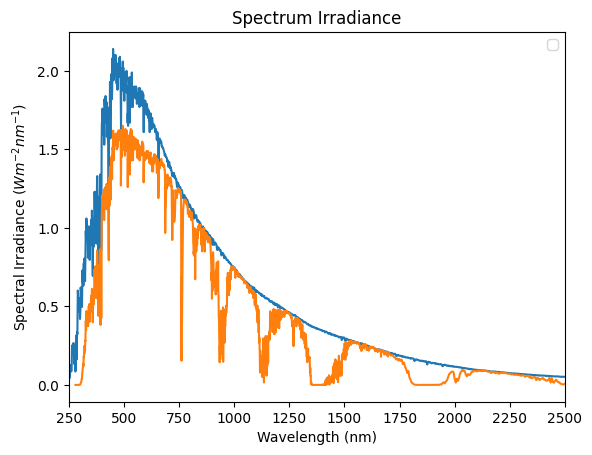

In [6]:
plt.plot(spectrumS[:, 0], spectrumS[:, 1])
plt.plot(spectrumE[:, 0], spectrumE[:, 1])

plt.xlim(left=250,right=2500)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}nm^{-1}$)')
plt.title('Spectrum Irradiance')
plt.legend()

original_irradianceS = np.trapz(spectrumS[:, 1], spectrumS[:, 0])
original_irradianceE = np.trapz(spectrumE[:, 1], spectrumE[:, 0])


print('Total spectrum AM0 irriadiance: ', original_irradianceS, 'W/m^2')
print('Total spectrum AM2.5 irriadiance: ', original_irradianceE, 'W/m^2')

In [7]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant')
# Globals
Tcell = 373  # temperature at Space (kelvin)
# Energy Gap
# The energy gap enetered here will be highlighted on upcoming plots. 
# Default is set to silicon bandgap 1.1eV

Egap = 1.6  #electron volts

# Silicon = 1.1eV

In [8]:
# A helper function that will do the job for us
def convert_spectrum(spectrum):
    """
    Spectrum input:
        y: Irradiance (W/m2/nm)
        x: Wavelength (nm)
    Converted otput:
        y: Number of photons (Np/m2/s/dE)
        x: Energy (eV)
    """
    converted = np.copy(spectrum)
    converted[:, 0] = converted[:, 0] * 1e-9  # wavelength to m
    converted[:, 1] = converted[:, 1] / 1e-9  # irradiance to W/m2/m (from W/m2/nm)

    E = h * c / converted[:, 0]
    d_lambda_d_E = h * c / E**2
    converted[:, 1] = converted[:, 1] * d_lambda_d_E * e / E
    converted[:, 0] = E / e
    return converted

If everything went okay this should be pretty close to the number from before
S : Original  1366.493806639  W/m^2	Converted  1366.4801908398379  W/m^2
E : Original  1000.4707036093448  W/m^2	Converted  1000.4707306185747  W/m^2


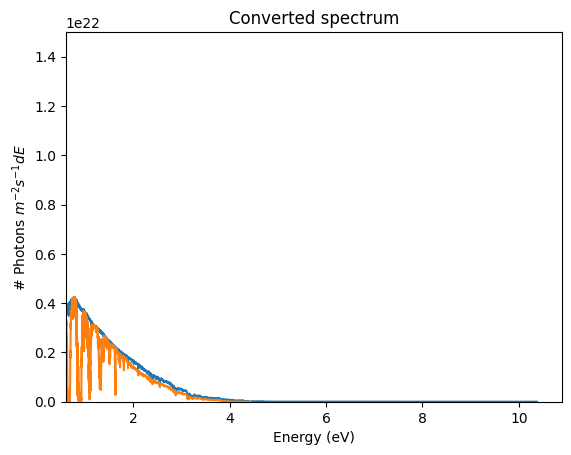

In [9]:
# Let's use the function, convert the input from the text file and have a look at it
photon_spectrumS = convert_spectrum(spectrumS)
photon_spectrumE = convert_spectrum(spectrumE)

plt.plot(photon_spectrumS[:,0], photon_spectrumS[:,1])
plt.plot(photon_spectrumE[:,0], photon_spectrumE[:,1])

plt.xlim(left=0.6)
plt.ylim(top=1.5*1e22,bottom=0)
plt.xlabel('Energy (eV)')
plt.ylabel('# Photons $m^{-2}s^{-1}dE$')
plt.title('Converted spectrum')

# Irradiance check
photon_irradianceS = np.trapz(photon_spectrumS[::-1, 1] * photon_spectrumS[::-1, 0],
                          photon_spectrumS[::-1, 0]) * e

photon_irradianceE = np.trapz(photon_spectrumE[::-1, 1] * photon_spectrumE[::-1, 0],
                          photon_spectrumE[::-1, 0]) * e


print('If everything went okay this should be pretty close to the number from before')
print('S : Original ', original_irradianceS, ' W/m^2\tConverted ', photon_irradianceS, ' W/m^2')
print('E : Original ', original_irradianceE, ' W/m^2\tConverted ', photon_irradianceE, ' W/m^2')

In [10]:
def photons_above_bandgap(egap, spectrum):
    """Counts number of photons above given bandgap"""
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1], x[::-1])


def photons_above_bandgap_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = photons_above_bandgap(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])

    p_above_1_1 = photons_above_bandgap(Egap, spectrum)
    plt.plot([Egap], [p_above_1_1], 'ro')
    plt.text(Egap+0.05, p_above_1_1, '{}eV, {:.4}'.format(Egap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('# Photons $m^{-2}s^{-1}$')
    plt.title('Number of above-bandgap \nphotons as a function of bandgap')
    plt.show()

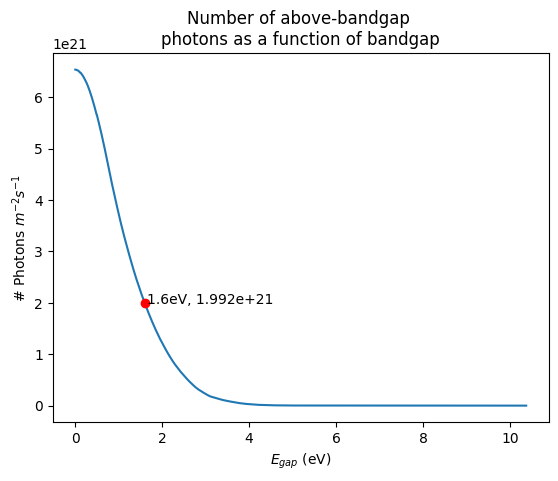

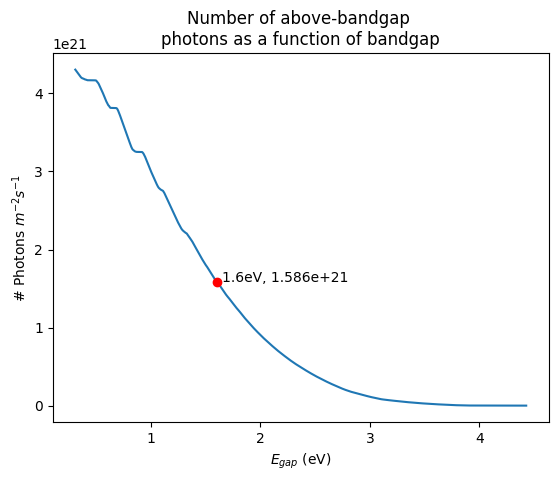

In [11]:
photons_above_bandgap_plot(photon_spectrumS)
photons_above_bandgap_plot(photon_spectrumE)

In [12]:
def rr0(egap, spectrum):
    k_eV = k / e
    h_eV = h / e
    const = (2 * np.pi) / (c**2 * h_eV**3)

    k_eV = k / e
    E = spectrum[::-1, ]  # in increasing order of bandgap energy
    egap_index = np.where(E[:, 0] >= egap)
    numerator = E[:, 0]**2
    exponential_in = E[:, 0] / (k_eV * Tcell)
    denominator = np.exp(exponential_in) - 1
    integrand = numerator / denominator

    integral = np.trapz(integrand[egap_index], E[egap_index, 0])

    result = const * integral
    return result[0]

In [13]:
def recomb_rate(egap, spectrum, voltage):
    print('recomb rate')
    return e * rr0(egap, spectrum) * np.exp(e * voltage / (k * Tcell))

In [14]:
def current_density(egap, spectrum, voltage):
    # print 'current_density'
    # print photons_above_bandgap(egap, spectrum), 'photons above bandgap'
    # print e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum)), 'photons above bandgap - rr0'
    return e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum) * np.exp(e * voltage / (k * Tcell)))


def jsc(egap, spectrum):
    # print 'jsc'
    return current_density(egap, spectrum, 0)


def voc(egap, spectrum):
    # print 'voc'
    return (k * Tcell / e) * np.log(photons_above_bandgap(egap, spectrum) / rr0(egap, spectrum))

In [15]:
# For an ideal solar cell these will be
print('At space,')
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', jsc(1.1, photon_spectrumS), 'A/m^2')
print('Ideal open circuit  voltage: ', voc(1.1, photon_spectrumS), 'V')
print('\n')
print('At Earth,')
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', jsc(1.1, photon_spectrumE), 'A/m^2')
print('Ideal open circuit  voltage: ', voc(1.1, photon_spectrumE), 'V')

At space,
A material with a bandgap of 1.60 will have an:
Ideal short circuit current:  541.859807461417 A/m^2
Ideal open circuit  voltage:  0.7989938043101628 V


At Earth,
A material with a bandgap of 1.60 will have an:
Ideal short circuit current:  442.3295868300462 A/m^2
Ideal open circuit  voltage:  0.7915562823940162 V


In [16]:
def ideal_jsc_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = jsc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    e_gap = 1.1
    p_above_1_1 = jsc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlim(left=0.5)
    plt.ylim(top=2000,bottom=0)
    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$J_{SC}$ $Am^{-2}$')
    plt.title('Ideal short-circuit current')


def ideal_voc_plot(spectrum):
    """Plot of the ideal open circuit voltage as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a[2:]:
        # print row
        row[1] = voc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    plt.plot(a[:, 0], a[:, 0])
    e_gap = 1.1
    p_above_1_1 = voc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$V_{OC}$ (V)')
    plt.xlim((0.5,4))
    plt.ylim((0,6))

    plt.title('Ideal open-circuit voltage. Straight line is bandgap.')

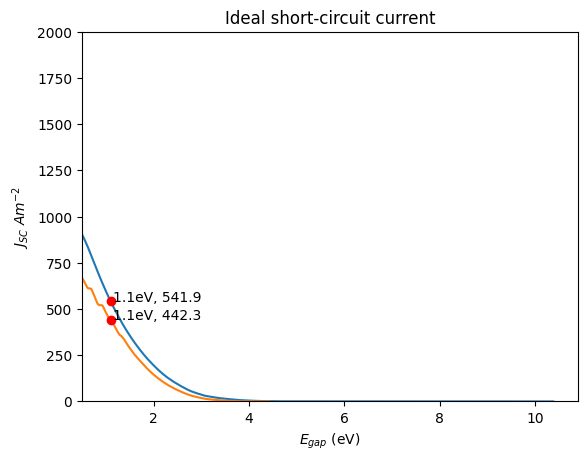

In [17]:
ideal_jsc_plot(photon_spectrumS)
ideal_jsc_plot(photon_spectrumE)


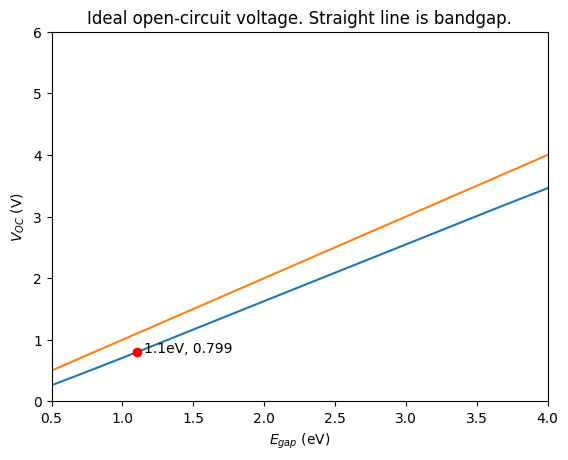

In [18]:
ideal_voc_plot(photon_spectrumS)

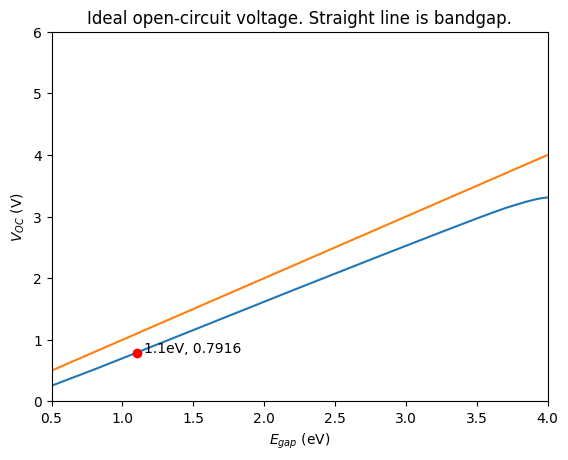

In [19]:
ideal_voc_plot(photon_spectrumE)

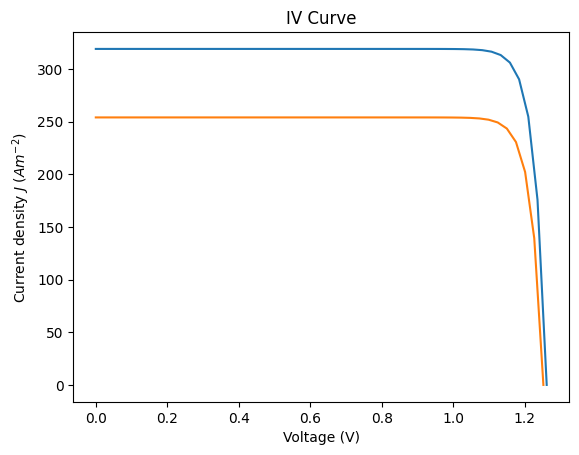

In [20]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, or the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)
    if power:
        p =  v * current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Power generated ($W$)')
        plt.title('Power Curve')
        plt.plot(v, p)
    else:
        i =  current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current density $J$ ($Am^{-2}$)')
        plt.title('IV Curve')
        plt.plot(v, i)
    
iv_curve_plot(Egap, photon_spectrumS)
iv_curve_plot(Egap, photon_spectrumE)


In [21]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, and the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)

    fig, ax1 = plt.subplots()
    p =  v * current_density(egap, spectrum, v)
    i =  current_density(egap, spectrum, v)
    
    ax1.plot(v, i)
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Current density $J$ ($Am^{-2}$)')
    ax1.legend(['Current'], loc=2)
    
    ax2 = ax1.twinx()
    ax2.plot(v, p, color='orange')
    ax2.set_ylabel('Power generated ($W$)')
    ax2.legend(['Power'], loc=3)
    return

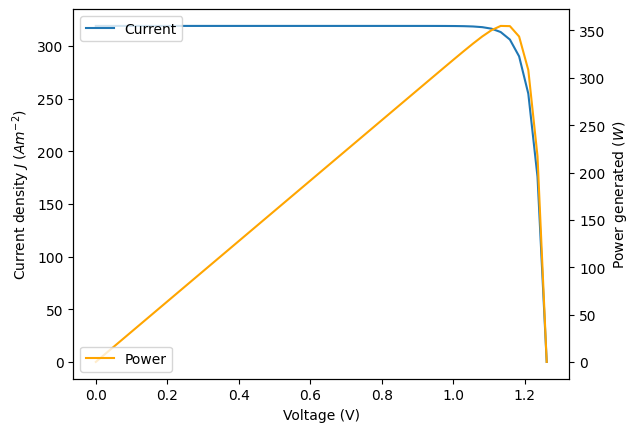

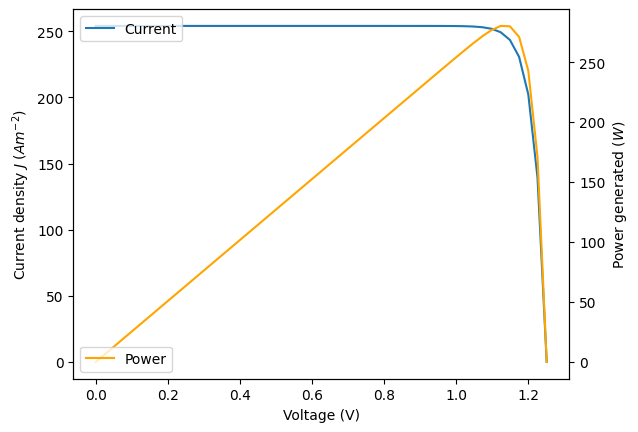

In [22]:
iv_curve_plot(Egap, photon_spectrumS)
iv_curve_plot(Egap, photon_spectrumE)

In [23]:
def v_at_mpp(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return v[index][0]


def j_at_mpp(egap, spectrum):
    return max_power(egap, spectrum) / v_at_mpp(egap, spectrum)


def max_power(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return max(v * current_density(egap, spectrum, v))


def max_eff(egap, spectrum):
    irradiance =  np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    # print photons_above_bandgap(egap, spectrum) * e
    return max_power(egap, spectrum) / irradiance

In [24]:
print('For a cell with bandgap %.2f eV' % Egap)
print('At space : Ideal efficiency is {:.4}%'.format(max_eff(Egap, photon_spectrumS)*100))
print('On earth : Ideal efficiency is {:.4}%'.format(max_eff(Egap, photon_spectrumE)*100))

For a cell with bandgap 1.60 eV
At space : Ideal efficiency is 25.96%
On earth : Ideal efficiency is 28.01%


optimal bandgap : 1.322 , Max Efficiency : 27.25%
optimal bandgap : 1.368 , Max Efficiency : 30.5%


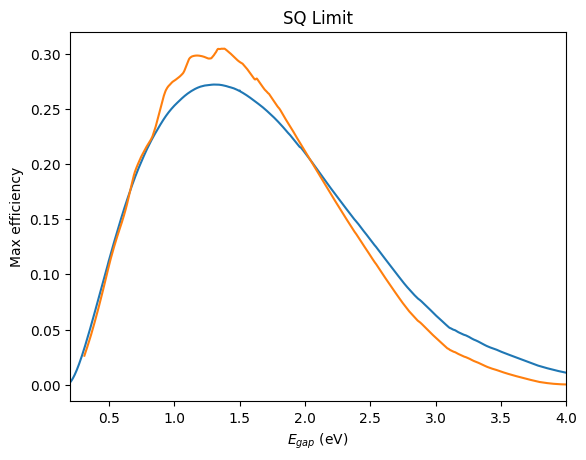

In [31]:
def sq_limit_plot(spectrum):
    # Plot the famous SQ limit
    a = np.copy(spectrum)
    # Not for whole array hack to remove divide by 0 errors
    for row in a[2:]:
        # print row
        row[1] = max_eff(row[0], spectrum)
    # Not plotting whole array becase some bad values happen
    plt.plot(a[2:, 0], a[2:, 1])

    opt_Eg_index = np.argmax(a[2:, 1])
    opt_Eg=spectrum[opt_Eg_index,0]

    max_Eff=max_eff(opt_Eg,spectrum)

    print('optimal bandgap : {:.4} , Max Efficiency : {:.4}%'.format(opt_Eg, max_Eff*100))
    # e_gap = Egap
    # p_above_1_1 = max_eff(e_gap, spectrum)
    # plt.plot([e_gap], [p_above_1_1], 'ro')
    # plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))
    plt.xlim((0.2,4))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('Max efficiency')
    plt.title('SQ Limit')


sq_limit_plot(photon_spectrumS)
sq_limit_plot(photon_spectrumE)